In [0]:
!nvidia-smi

Sat Nov 30 16:47:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [0]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169817 sha256=582586c93d89f455a131cb44a7146c20a73d559a3b55117cb653ebbba4aa855e
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [0]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [0]:
!pip install gdown
!pip install tensorflow-gpu

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
!gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output indian_number_plates.json

Downloading...
From: https://drive.google.com/uc?id=1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT
To: /content/keras-retinanet/indian_number_plates.json
100% 92.5k/92.5k [00:00<00:00, 81.3MB/s]


In [0]:
os.makedirs("snapshots", exist_ok=True)

In [0]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:01, 167MB/s]


In [0]:
plates_df = pd.read_json('indian_number_plates.json', lines=True)

In [0]:
os.makedirs("number_plates", exist_ok=True)

In [0]:
dataset = dict()
dataset["image_name"] = list()
dataset["x_min"] = list()
dataset["y_min"] = list()
dataset["x_max"] = list()
dataset["y_max"] = list()
dataset["class_name"] = list()

counter = 0
for index, row in plates_df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save(f'number_plates/licensed_car_{counter}.jpeg', "JPEG")
    
    dataset["image_name"].append(f'number_plates/licensed_car_{counter}.jpeg')
    
    data = row["annotation"]
  
    width = data[0]["imageWidth"]
    height = data[0]["imageHeight"]

    dataset["x_min"].append(int(round(data[0]["points"][0]["x"] * width)))
    dataset["y_min"].append(int(round(data[0]["points"][0]["y"] * height)))
    dataset["x_max"].append(int(round(data[0]["points"][1]["x"] * width)))
    dataset["y_max"].append(int(round(data[0]["points"][1]["y"] * height)))
    dataset["class_name"].append("license_plate")
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [0]:
df = pd.DataFrame(dataset)
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,number_plates/licensed_car_0.jpeg,582,274,700,321,license_plate
1,number_plates/licensed_car_1.jpeg,80,382,288,449,license_plate
2,number_plates/licensed_car_2.jpeg,41,219,115,260,license_plate
3,number_plates/licensed_car_3.jpeg,217,313,359,359,license_plate
4,number_plates/licensed_car_4.jpeg,209,220,866,554,license_plate


In [0]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

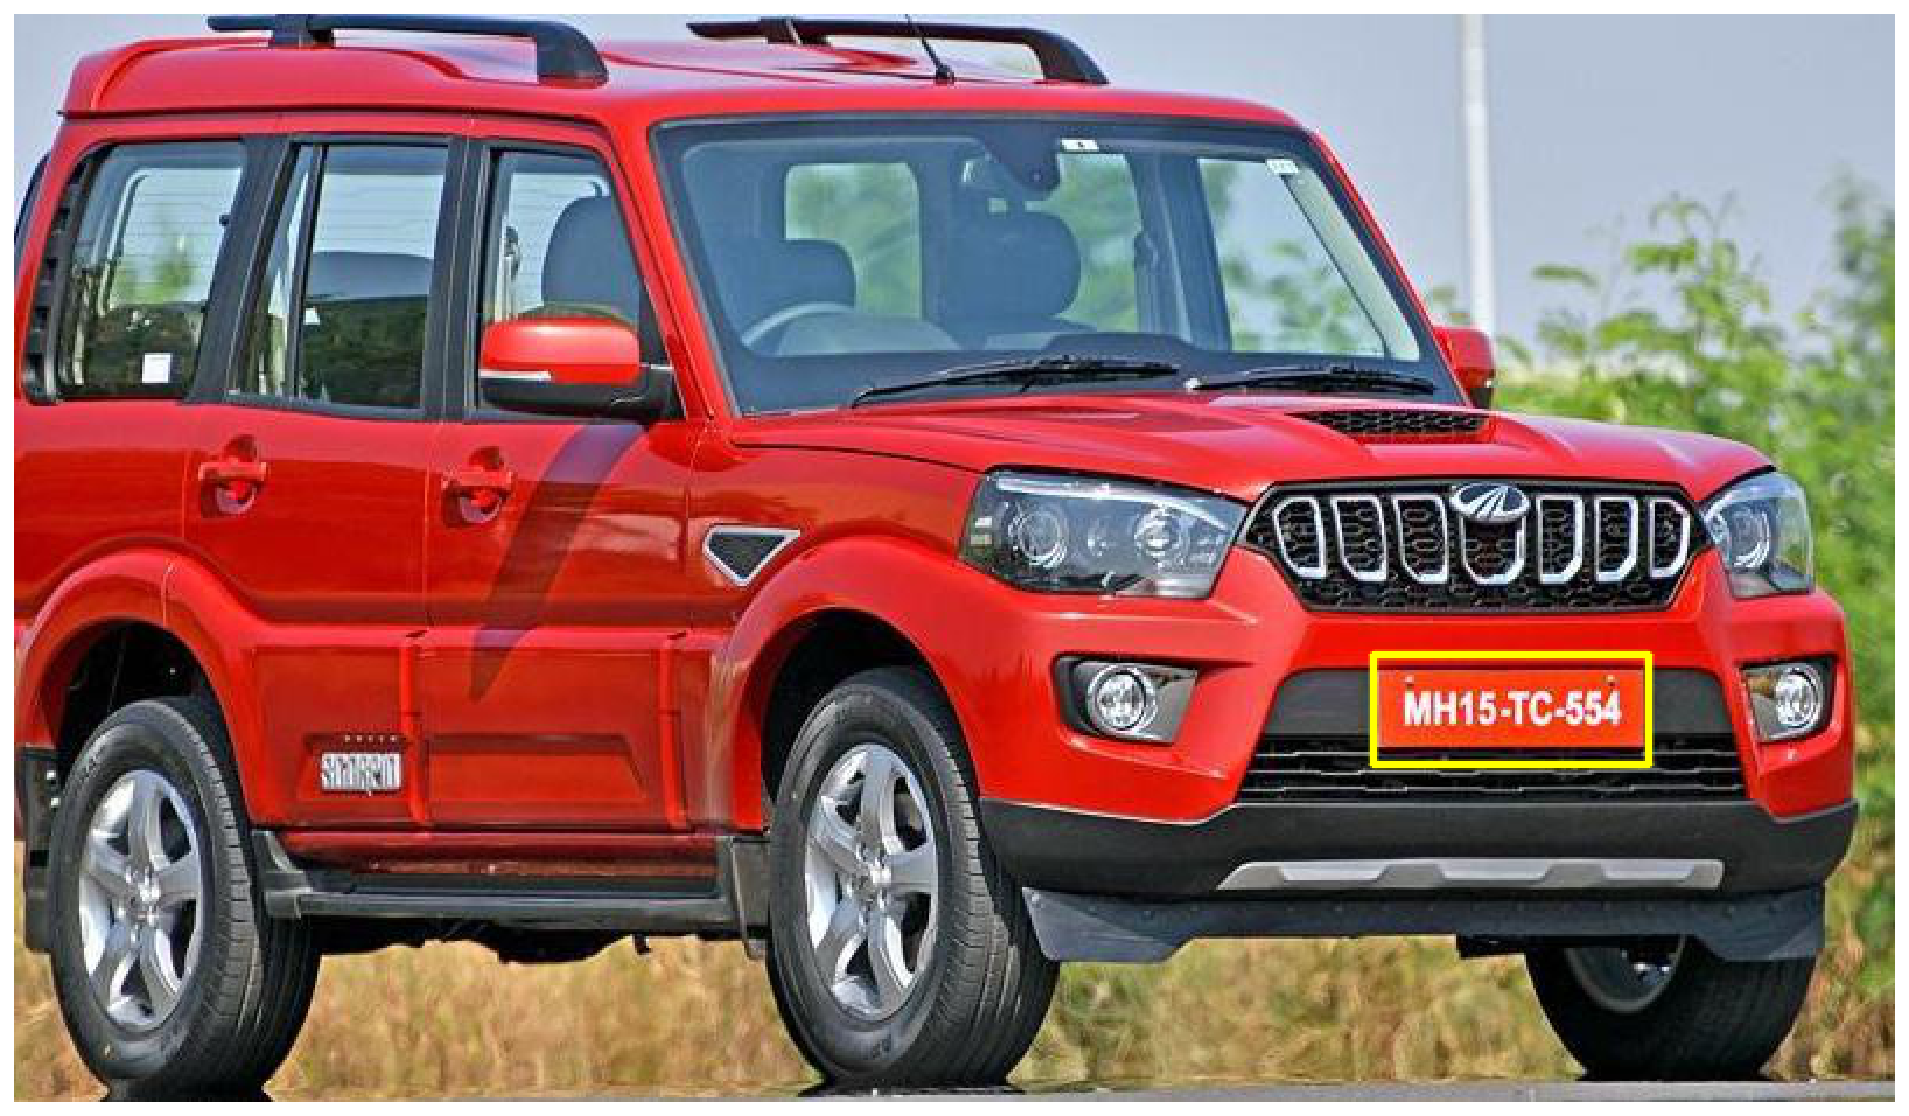

In [0]:
show_image_objects(df.iloc[0])

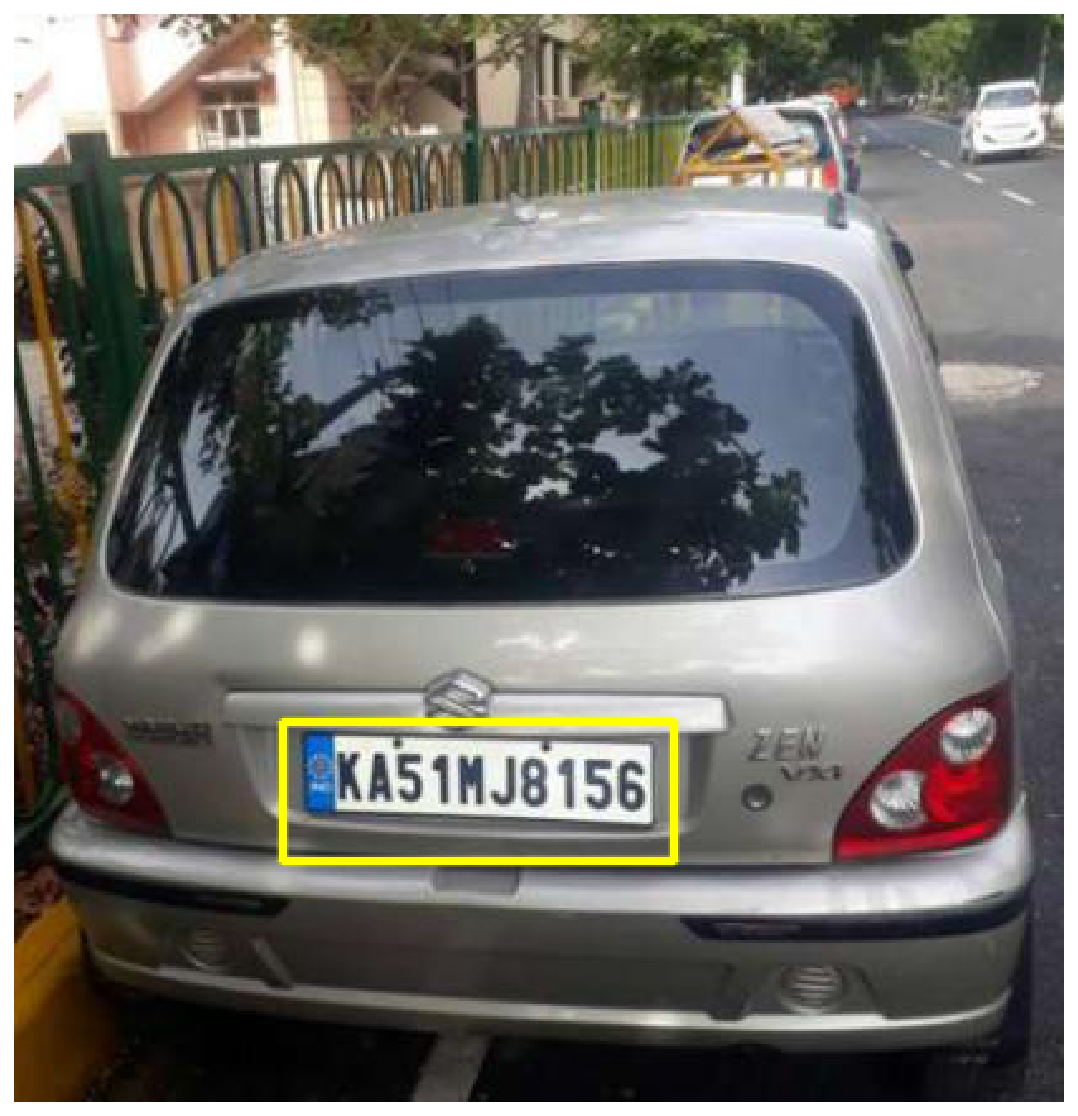

In [0]:
show_image_objects(df.iloc[5])

# Preprocessing

In [0]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [0]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [0]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [0]:
classes = set(['license_plate'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [0]:
!head classes.csv

license_plate,0


In [0]:
!head annotations.csv

number_plates/licensed_car_183.jpeg,169,260,358,298,license_plate
number_plates/licensed_car_201.jpeg,251,187,375,234,license_plate
number_plates/licensed_car_230.jpeg,140,149,324,220,license_plate
number_plates/licensed_car_95.jpeg,302,420,671,534,license_plate
number_plates/licensed_car_190.jpeg,115,86,227,117,license_plate
number_plates/licensed_car_84.jpeg,103,209,258,276,license_plate
number_plates/licensed_car_158.jpeg,83,34,369,483,license_plate
number_plates/licensed_car_97.jpeg,123,117,221,170,license_plate
number_plates/licensed_car_147.jpeg,162,227,312,274,license_plate
number_plates/licensed_car_184.jpeg,100,148,259,208,license_plate


# Training

In [0]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [0]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

Using TensorFlow backend.
Creating model, this may take a second...
2019-11-30 16:49:49.863266: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-11-30 16:49:49.911632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-11-30 16:49:49.912231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2019-11-30 16:49:49.920123: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2019-11-30 16:49:50.120471: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2019-11-30 16:49:50.212758: I tensorflow/stream_executor/platfo

# Loading the trained model

In [0]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_04.h5  resnet50_csv_08.h5
resnet50_csv_01.h5    resnet50_csv_05.h5  resnet50_csv_09.h5
resnet50_csv_02.h5    resnet50_csv_06.h5  resnet50_csv_10.h5
resnet50_csv_03.h5    resnet50_csv_07.h5


In [0]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [

# Predictions

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [0]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)


In [0]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [0]:
test_df.head(n=10)

,image_name,x_min,y_min,x_max,y_max,class_name
115,number_plates/licensed_car_115.jpeg,48,74,599,188,license_plate
15,number_plates/licensed_car_15.jpeg,274,344,517,431,license_plate
211,number_plates/licensed_car_211.jpeg,157,89,382,160,license_plate
126,number_plates/licensed_car_126.jpeg,443,255,639,347,license_plate
6,number_plates/licensed_car_6.jpeg,227,241,444,315,license_plate
170,number_plates/licensed_car_170.jpeg,556,442,1746,1079,license_plate
9,number_plates/licensed_car_9.jpeg,674,365,958,572,license_plate
221,number_plates/licensed_car_221.jpeg,93,332,298,406,license_plate
112,number_plates/licensed_car_112.jpeg,22,50,499,362,license_plate
220,number_plates/licensed_car_220.jpeg,55,191,194,238,license_plate


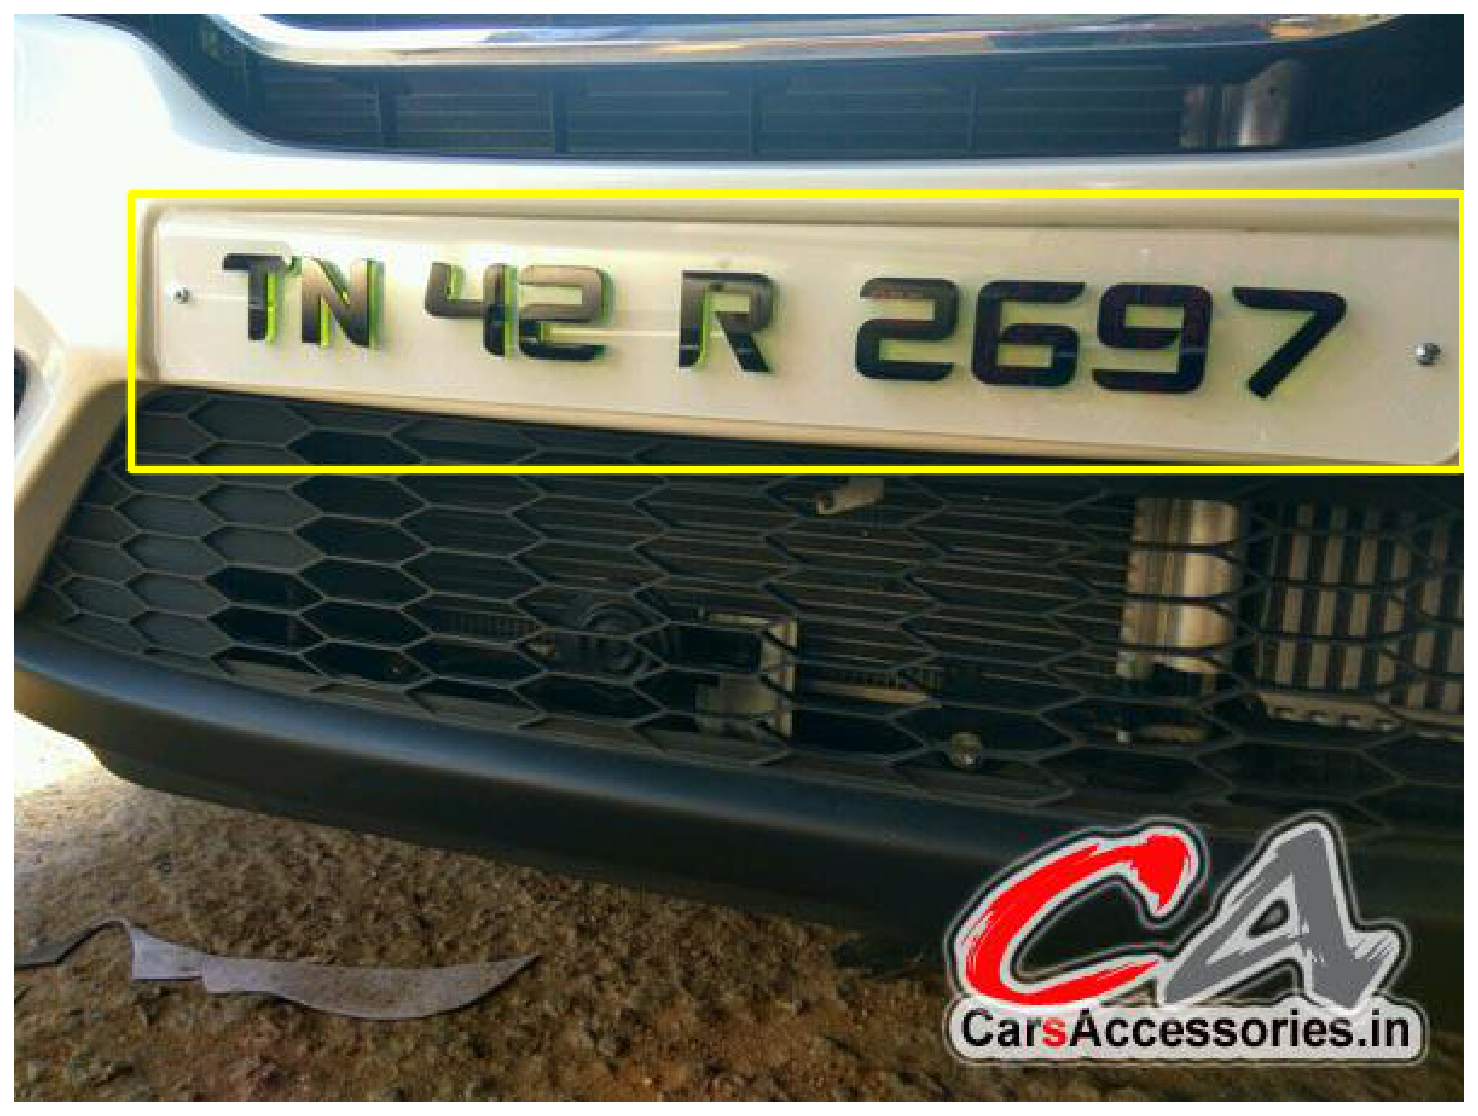

In [0]:
show_detected_objects(test_df.iloc[0])

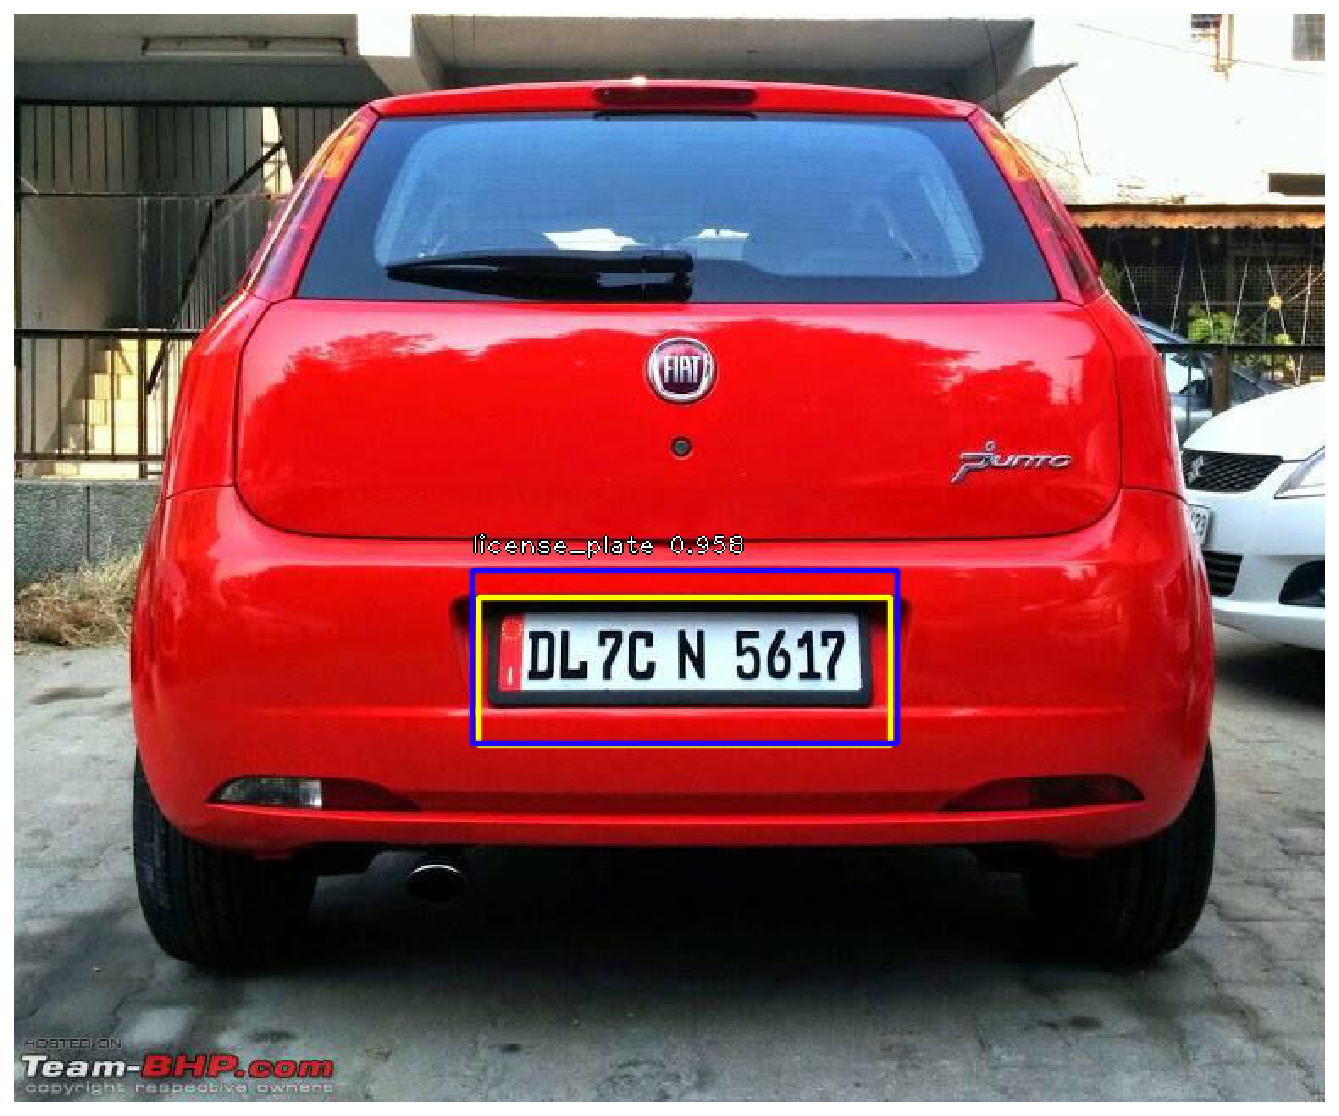

In [0]:
show_detected_objects(test_df.iloc[1])

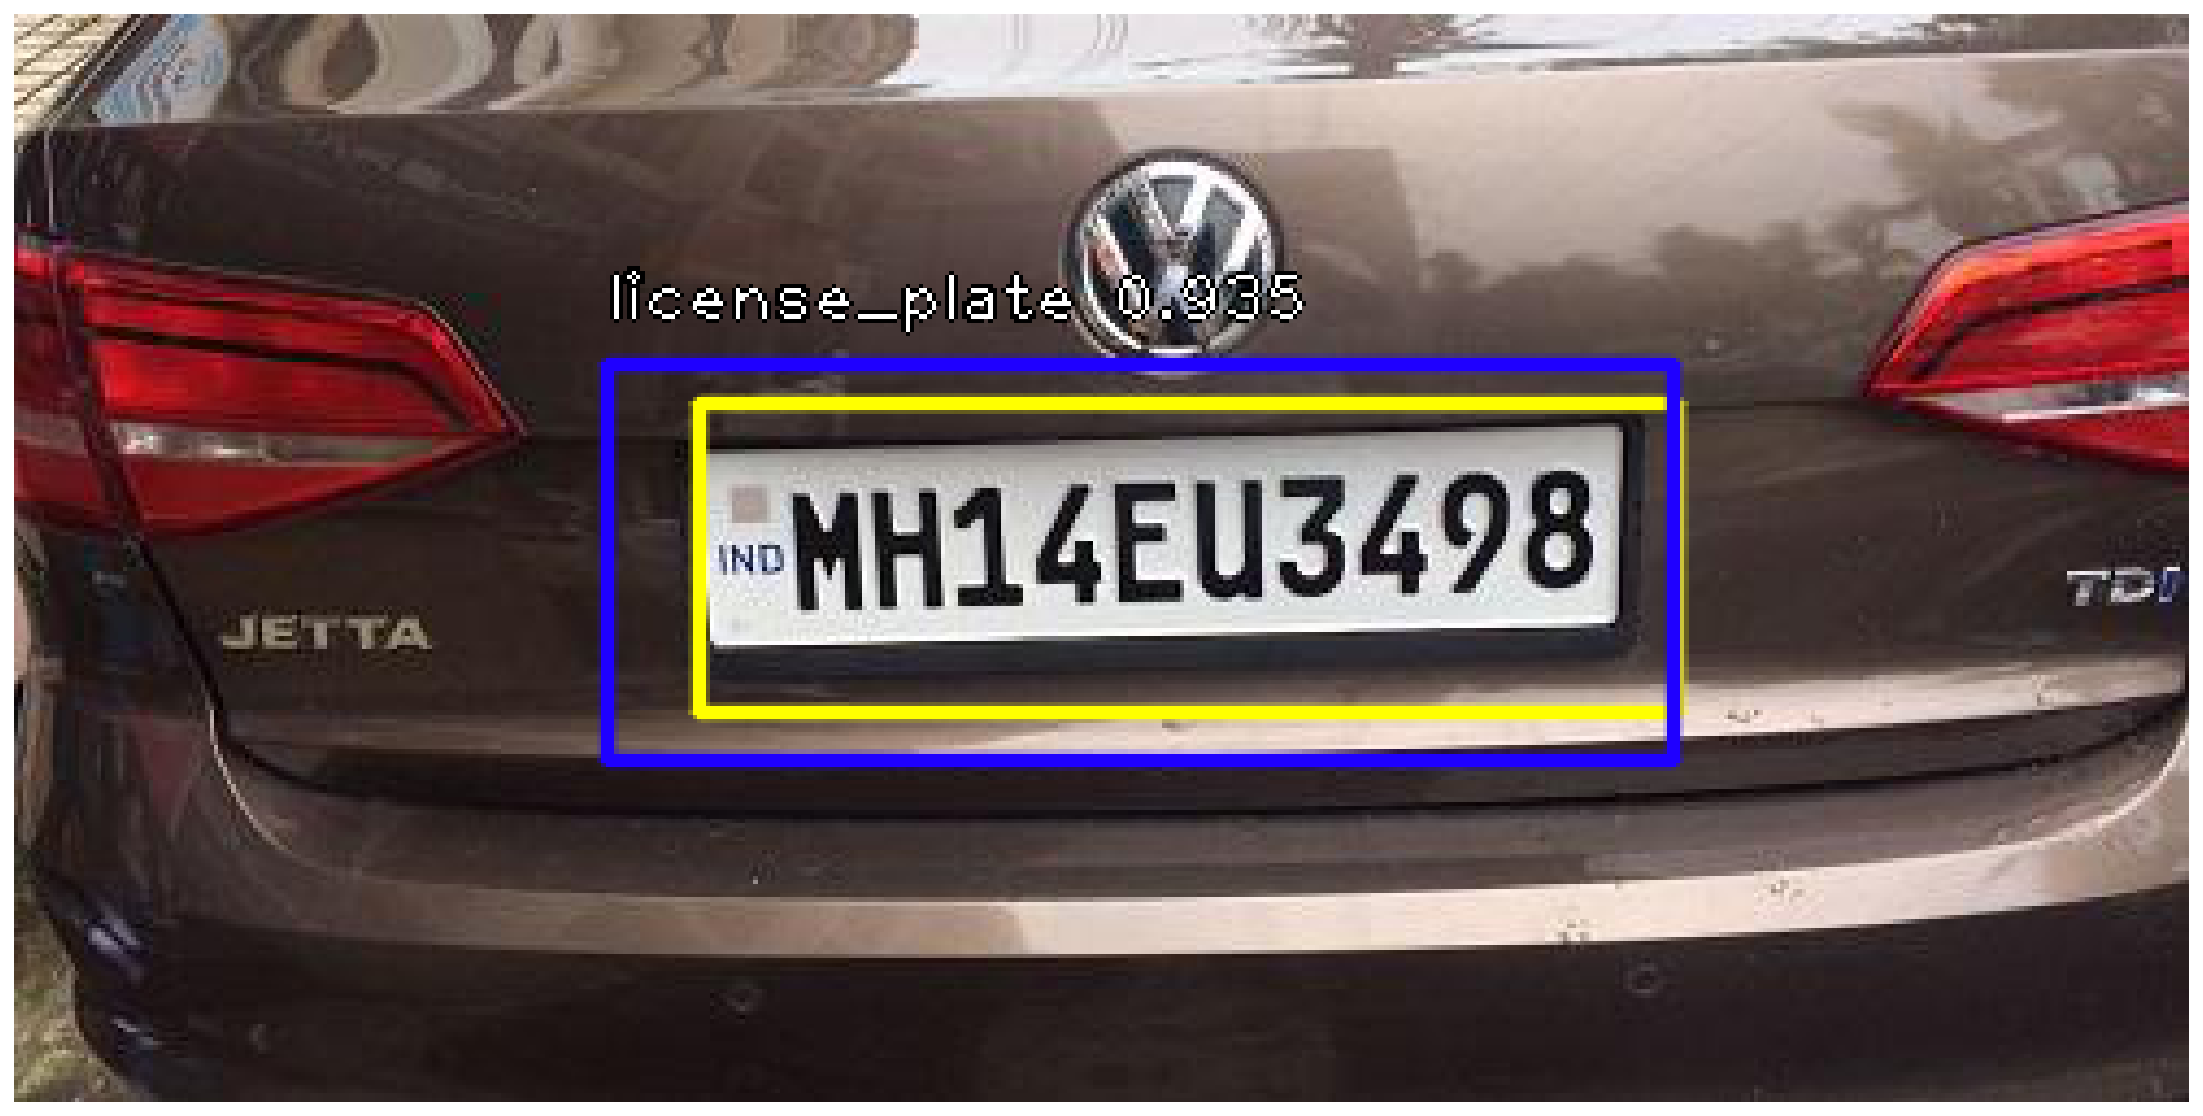

In [0]:
show_detected_objects(test_df.iloc[2])